# Transformer example

## Imports

In [2]:
import numpy as np
from pathlib import Path
import torch
import torch.nn as nn
from pathlib import Path
from torch.utils.data import TensorDataset, DataLoader, random_split
import matplotlib.pyplot as plt

## Normalize input and output features

In [25]:
data_dir = Path("../../../../ddemler/dima_stuff/wa_remake/May_15_processed")
max_samples = 10000

feat_np  = np.load(data_dir / "combined_features.npy")[:max_samples]  # (N, 18, 16)
label_np = np.load(data_dir / "combined_labels.npy")[:max_samples]    # (N, 5)

pad_mask_np = np.all(feat_np == -1, axis=-1)

valid_rows = feat_np[~pad_mask_np]
means = valid_rows.mean(axis=0)
stds  = valid_rows.std(axis=0)
stds[stds < 1e-5] = 1.0
feat_np = np.where(feat_np == -1, 0, feat_np)
feat_np = (feat_np - means) / stds

# --- Tensor conversion ---
feat     = torch.from_numpy(feat_np).float()
pad_mask = torch.from_numpy(pad_mask_np)
label    = torch.from_numpy(label_np).float()

dataset = TensorDataset(feat, pad_mask, label)
N = len(dataset)
train_size = int(0.7 * N)
val_size   = int(0.15 * N)
test_size  = N - train_size - val_size
generator = torch.Generator().manual_seed(42)
train_ds, val_ds, test_ds = torch.utils.data.random_split(
    dataset, [train_size, val_size, test_size], generator=generator)

# --- Extract all train labels for label normalization ---
train_labels = torch.stack([train_ds[i][2] for i in range(len(train_ds))])  # (num_train, 5)
label_means = train_labels.mean(dim=0)
label_stds = train_labels.std(dim=0)
label_stds[label_stds < 1e-5] = 1.0

# --- Define a transform for normalization ---
def normalize_labels(labels, means, stds):
    return (labels - means) / stds

def unnormalize_labels(normed_labels, means, stds):
    return normed_labels * stds + means

# --- Normalize all labels in your datasets ---
def normalized_dataset(dataset, means, stds):
    new_tensors = []
    for feat, pad, label in dataset:
        norm_label = (label - means) / stds
        new_tensors.append((feat, pad, norm_label))
    return new_tensors

train_norm = normalized_dataset(train_ds, label_means, label_stds)
val_norm   = normalized_dataset(val_ds, label_means, label_stds)
test_norm  = normalized_dataset(test_ds, label_means, label_stds)

train_loader = DataLoader(train_norm, batch_size=512, shuffle=True)
val_loader   = DataLoader(val_norm, batch_size=512, shuffle=False)
test_loader  = DataLoader(test_norm, batch_size=512, shuffle=False)

print(f"Train samples: {len(train_loader.dataset)}")
print(f"Val   samples: {len(val_loader.dataset)}")
print(f"Test  samples: {len(test_loader.dataset)}")

Train samples: 7000
Val   samples: 1500
Test  samples: 1500


## Dataloader

In [16]:
# load arrays
#data_dir    = Path("../../../ddemler/dima_stuff/wa_remake/May12_full_converted_dataset")
# data_dir    = Path ("../../../ddemler/dima_stuff/wa_remake/May_14_processed")
data_dir    = Path ("../../../../ddemler/dima_stuff/wa_remake/May_15_processed")
feat_np     = np.load(data_dir / "combined_features.npy") # shape (N, 18, 16)
label_np    = np.load(data_dir / "combined_labels.npy") # shape (N, 5)

# padding mask: true when an entire row is -1 (padded rows)
pad_mask_np = np.all(feat_np == -1, axis=-1) # shape (N, 18)

# replace -1 padding with 0
feat_np = np.where(feat_np == -1, 0, feat_np)

# convert to torch tensor
feat     = torch.from_numpy(feat_np).float() # (N, seq_len, dim): (440198, 18, 16)
pad_mask = torch.from_numpy(pad_mask_np) # (N, seq_len), bool: (440198, 18), bool (True means that the token was padded)
label    = torch.from_numpy(label_np).float() # (N, 5): (440198, 5)

# single dataset
dataset = TensorDataset(feat, pad_mask, label)
N = len(dataset)

# 70/30 split
train_size = int(0.7 * N)
test_size  = N - train_size
generator  = torch.Generator().manual_seed(42)
train_ds, test_ds = random_split(dataset, [train_size, test_size], generator=generator)

# dataloaders
train_loader = DataLoader(train_ds, batch_size=512, shuffle=True)
test_loader  = DataLoader(test_ds,  batch_size=512, shuffle=False)

print(f"Train samples: {len(train_ds)}")
print(f"Test samples: {len(test_ds)}")

Train samples: 314238
Test samples: 134674


## Normalized data

In [51]:
import numpy as np
import torch
from pathlib import Path
from torch.utils.data import TensorDataset, DataLoader, random_split

# Load raw arrays
data_dir = Path("../../../../ddemler/dima_stuff/wa_remake/May_15_processed")
max_samples = 10000 # FOR TESTING - REMOVE WHEN DONE

# Load raw input features and labels
feat_np_raw = np.load(data_dir / "combined_features.npy")[:max_samples]  # Shape: (N, 18, 16)
label_np = np.load(data_dir / "combined_labels.npy")[:max_samples]       # Shape: (N, 6)

# Build padding mask (True = padded layer)
pad_mask_np = np.all(feat_np_raw == -1, axis=-1)  # Shape: (N, 18)

# Collect all non-padded rows into one big matrix
valid_rows = feat_np_raw[~pad_mask_np]  # Shape: (total_valid_rows, 16)

# Compute mean/std across every column
means = valid_rows.mean(axis=0)  # Shape: (16,)
stds = valid_rows.std(axis=0)    # Shape: (16,)
stds[stds < 1e-5] = 1.0          # Avoid division by zero

# Zero-fill the original –1’s (value won’t matter once masked)
feat_np = np.where(feat_np_raw == -1, 0, feat_np_raw)  # Shape: (N, 18, 16)

# Normalize all 16 feature-columns in place
feat_np = (feat_np - means) / stds  # Broadcasting to shape: (N, 18, 16)

# Convert everything to torch tensors
feat = torch.from_numpy(feat_np).float()             # Shape: (N, 18, 16)
pad_mask = torch.from_numpy(pad_mask_np)             # Shape: (N, 18), bool
label = torch.from_numpy(label_np).float()           # Shape: (N, 6)

# Create dataset
dataset = TensorDataset(feat, pad_mask, label)
N = len(dataset)

# Split dataset into train, validation, and test sets (70/15/15)
train_size = int(0.7 * N)
val_size = int(0.15 * N)
test_size = N - train_size - val_size  # Ensures all samples are used

generator = torch.Generator().manual_seed(42)
train_ds, val_ds, test_ds = random_split(dataset, [train_size, val_size, test_size], generator=generator)

# Create DataLoaders
train_loader = DataLoader(train_ds, batch_size=512, shuffle=True)
val_loader = DataLoader(val_ds, batch_size=512, shuffle=False)
test_loader = DataLoader(test_ds, batch_size=512, shuffle=False)

print(f"Train samples: {len(train_ds)}")
print(f"Validation samples: {len(val_ds)}")
print(f"Test samples: {len(test_ds)}")

Train samples: 7000
Validation samples: 1500
Test samples: 1500


## Check Normalization

In [17]:
import numpy as np
import torch
from pathlib import Path
from torch.utils.data import TensorDataset, DataLoader, random_split

# --- Load data ---
data_dir    = Path("../../../../ddemler/dima_stuff/wa_remake/May_15_processed")
feat_np     = np.load(data_dir / "combined_features.npy")  # (N, 18, 16)
label_np    = np.load(data_dir / "combined_labels.npy")    # (N,  5)

# --- Build padding mask (True = padded layer) ---
pad_mask_np = np.all(feat_np == -1, axis=-1)               # (N, 18)

# --- Collect all non-padded rows into one big matrix ---
valid_rows = feat_np[~pad_mask_np]                         # (total_valid_rows, 16)

# --- Compute mean/std across every column ---
means = valid_rows.mean(axis=0)                            # (16,)
stds  = valid_rows.std(axis=0)                             # (16,)
stds[stds < 1e-5] = 1.0                                    # avoid zero division

# --- Save for display before normalization ---
means_before = means.copy()
stds_before  = stds.copy()

# --- Zero-fill the original -1's (will be masked out) ---
feat_np = np.where(feat_np == -1, 0, feat_np)              # (N,18,16)

# --- Normalize all 16 feature-columns in place ---
feat_np_normed = (feat_np - means) / stds                  # new normalized array

# --- After normalization, get means/stds for non-padded rows again ---
normed_valid_rows = (valid_rows - means) / stds
means_after = normed_valid_rows.mean(axis=0)
stds_after  = normed_valid_rows.std(axis=0)

# --- Print compact summary table ---
print(f"{'Idx':>3} {'Feature':>14} | {'Mean (before)':>13} {'Std (before)':>13} | {'Mean (after)':>12} {'Std (after)':>11}")
print("-"*68)
input_features = [
    "d_in1", "d_in2", "d_in3", "d_out1", "d_out2", "d_out3", "prec", "rf",
    "strategy", "layer_type", "activation_type", "filters", "kernel_size",
    "stride", "padding", "pooling"
]
for i, name in enumerate(input_features):
    print(f"{i:>3} {name:>14} | {means_before[i]:13.4f} {stds_before[i]:13.4f} | {means_after[i]:12.4f} {stds_after[i]:11.4f}")

Idx        Feature | Mean (before)  Std (before) | Mean (after) Std (after)
--------------------------------------------------------------------
  0          d_in1 |       69.2388      176.7285 |       0.0000      1.0000
  1          d_in2 |        1.0230        5.2855 |       0.0000      1.0000
  2          d_in3 |        0.2257        1.6375 |      -0.0000      1.0000
  3         d_out1 |       69.4984      176.7855 |      -0.0000      1.0000
  4         d_out2 |        0.6247        3.3734 |       0.0000      1.0000
  5         d_out3 |        0.1754        1.4449 |       0.0000      1.0000
  6           prec |        9.5652        5.2101 |       0.0000      1.0000
  7             rf |     2165.1471     4809.2434 |      -0.0000      1.0000
  8       strategy |        1.0000        1.0000 |       0.0000      0.0000
  9     layer_type |        0.6859        1.2142 |       0.0000      1.0000
 10 activation_type |        0.5653        0.7179 |       0.0000      1.0000
 11        filters

## Tokenization

In [39]:
class LayerTokenizer(nn.Module):
    def __init__(self, feature_dim: int = 16, embed_dim:   int = 512, max_layers:  int = 128):
        """
        feature_dim: feature length per layer: 16
        embed_dim: token dimension (here 512)
        max_layers: max supported layers for learned positional embeddings
        """
        super().__init__()
        # map features to token embeddings
        self.linear = nn.Linear(feature_dim, embed_dim)
        # positional embeddings
        self.pos_emb = nn.Parameter(torch.randn(max_layers, embed_dim))
        # CLS token for a summary of the whole model
        self.cls_token = nn.Parameter(torch.randn(1, 1, embed_dim))

    def forward(self, x: torch.Tensor):
        """
        x: (B, L, feature_dim), L = # layers (variable <= max_layers)
        """
        B, L, _ = x.shape
        # map to tokens
        tokens = self.linear(x) # (B, L, 512)
        # add positional embeddings for first L positions
        tokens = tokens + self.pos_emb[:L, :].unsqueeze(0)
        # CLS token prepend
        cls   = self.cls_token.expand(B, -1, -1) # (B, 1, 512)
        tokens = torch.cat([cls, tokens], dim=1) # (B, L+1, 512)

        return tokens

## Model

In [40]:
class TransformerRegressor(nn.Module):
    def __init__(self,
                 feature_dim: int = 16, # input features
                 embed_dim:   int = 512,
                 num_heads:   int = 8,
                 ff_dim:      int = 512,
                 num_layers:  int = 2,
                 output_dim:  int = 6, # output features
                 max_layers:  int = 18,
                 dropout:     float = 0.1):
        super().__init__()
        # tokenize each layer
        self.tokenizer = LayerTokenizer(feature_dim, embed_dim, max_layers)
        # transformer encoder stack
        encoder_layer = nn.TransformerEncoderLayer(
            d_model=embed_dim,
            nhead=num_heads,
            dim_feedforward=ff_dim,
            dropout=dropout,
            batch_first=False
        )
        self.transformer = nn.TransformerEncoder(encoder_layer, num_layers)
        # regression head to ouptut
        self.head = nn.Linear(embed_dim, output_dim)

    def forward(self, x, pad_mask):
        """
        x:        (B, L,  feature_dim)
        pad_mask: (B, L)     True=padding
        returns:
          preds:  (B, output_dim)
        """
        B, L, _ = x.shape
        # tokenize and CLS
        tokens = self.tokenizer(x) # (B, L+1, E)
        # extend pad_mask for the CLS position (never masked)
        cls_pad = torch.zeros(B, 1, dtype=torch.bool, device=x.device)
        mask = torch.cat([cls_pad, pad_mask], dim=1)  # (B, L+1)

        # needs (S, B, E)
        tokens = tokens.transpose(0, 1) # (L+1, B, E)
        # apply encoder
        out = self.transformer(tokens, src_key_padding_mask=mask)
        # take CLS output (first token)
        cls_out = out[0] # (B, E)
        # map to targets
        return self.head(cls_out) # (B, 5)

## Train

In [41]:
device    = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model     = TransformerRegressor().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=1)
loss_fn   = nn.MSELoss()

num_epochs = 10
train_losses = []
val_losses = []

for epoch in range(1, num_epochs+1):
    model.train()
    train_loss = 0.0
    for feats, pad_mask, labels in train_loader:
        feats, pad_mask, labels = feats.to(device), pad_mask.to(device), labels.to(device)
        optimizer.zero_grad()
        preds = model(feats, pad_mask)
        loss  = loss_fn(preds, labels)
        loss.backward()
        optimizer.step()
        train_loss += loss.item() * feats.size(0)
    train_loss /= len(train_loader.dataset)
    train_losses.append(train_loss)

    model.eval()
    val_loss = 0.0
    with torch.no_grad():
        for feats, pad_mask, labels in val_loader:
            feats, pad_mask, labels = feats.to(device), pad_mask.to(device), labels.to(device)
            preds = model(feats, pad_mask)
            val_loss += loss_fn(preds, labels).item() * feats.size(0)
    val_loss /= len(val_loader.dataset)
    val_losses.append(val_loss)

    print(f"Epoch {epoch:2d} — Train Loss: {train_loss:.4f} | Validation Loss: {val_loss:.4f}")

/home/users/jdweitz/miniconda3/envs/rule4ml_env/lib/python3.10/site-packages/torch/nn/modules/transformer.py:385: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(


Epoch  1 — Train Loss: 9812377080.9783 | Validation Loss: 5737256864.4267
Epoch  2 — Train Loss: 5911724165.4126 | Validation Loss: 5377949797.0347
Epoch  3 — Train Loss: 5675294144.2194 | Validation Loss: 5347812702.8907
Epoch  4 — Train Loss: 5657705959.4240 | Validation Loss: 5339737670.9973
Epoch  5 — Train Loss: 5671522974.5737 | Validation Loss: 5340243689.4720
Epoch  6 — Train Loss: 5666066972.6720 | Validation Loss: 5364864464.2133
Epoch  7 — Train Loss: 5657528672.2560 | Validation Loss: 5338262919.8507
Epoch  8 — Train Loss: 5653586344.8137 | Validation Loss: 5342988473.6853
Epoch  9 — Train Loss: 5650855897.9657 | Validation Loss: 5343137293.6533
Epoch 10 — Train Loss: 5652980741.2663 | Validation Loss: 5338012550.4853


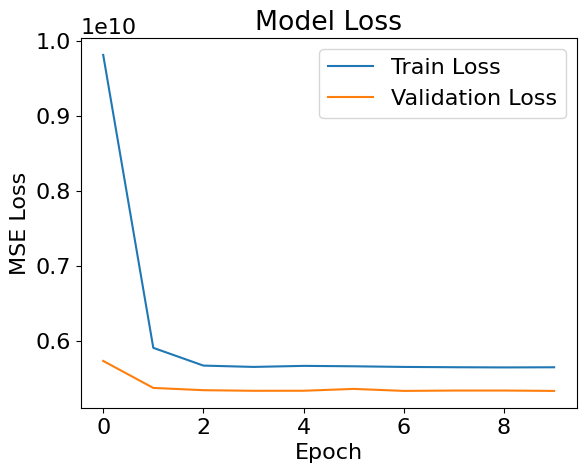

In [42]:

plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses,   label='Validation Loss')
plt.xlabel("Epoch")
plt.ylabel("MSE Loss")
plt.legend()
plt.title("Model Loss")
plt.show()

## Test

In [43]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

def calculate_metrics(y_true, y_pred):
    ''' Calculate out MAE, MSE, RMSE, R^2, and SMAPE '''
    mae = mean_absolute_error(y_true, y_pred)
    mse = mean_squared_error(y_true, y_pred)
    rmse = np.sqrt(mse)
    r2 = r2_score(y_true, y_pred)
    smape = (100 / len(y_true)) * np.sum(
        2 * np.abs(y_pred - y_true) / (np.abs(y_true) + np.abs(y_pred) + 1e-8)
    )
    print(f'Symmetric mean absolute percentage error (SMAPE): {smape:.4f}')
    print(f'Mean Absolute Error (MAE): {mae:.4f}')
    print(f'Mean Squared Error (MSE): {mse:.4f}')
    print(f'Root Mean Squared Error (RMSE): {rmse:.4f}')
    print(f'R-squared (R2 Score): {r2:.4f}')
    return dict(smape=smape, mae=mae, mse=mse, rmse=rmse, r2=r2)

In [44]:
# model.eval()
# test_loss = 0.0
# with torch.no_grad():
#     for feats, pad_mask, labels in test_loader:
#         feats, pad_mask, labels = feats.to(device), pad_mask.to(device), labels.to(device)
#         preds = model(feats, pad_mask)
#         test_loss += loss_fn(preds, labels).item() * feats.size(0)
# test_loss /= len(test_loader.dataset)
# print(f"Test Loss: {test_loss:.4f}")

y_true_list = []
y_pred_list = []

model.eval()
with torch.no_grad():
    for feats, pad_mask, labels in test_loader:
        feats, pad_mask = feats.to(device), pad_mask.to(device)
        preds = model(feats, pad_mask).cpu()
        y_true_list.append(labels.cpu().numpy())
        y_pred_list.append(preds.numpy())

y_true = np.vstack(y_true_list)
y_pred = np.vstack(y_pred_list)

calculate_metrics(y_true, y_pred)

Symmetric mean absolute percentage error (SMAPE): 534.6798
Mean Absolute Error (MAE): 37236.5742
Mean Squared Error (MSE): 6056843776.0000
Root Mean Squared Error (RMSE): 77825.7270
R-squared (R2 Score): -49.3822


{'smape': 534.6797526041667,
 'mae': 37236.57421875,
 'mse': 6056843776.0,
 'rmse': 77825.72695452321,
 'r2': -49.38222122192383}

## Plot

In [45]:
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
import numpy as np
import os

def plot_box_plots_symlog(y_pred, y_test, folder_name):
    # Columns: ["WorstLatency_hls", "IntervalMax_hls", "FF_hls", "LUT_hls", "BRAM_18K_hls", "DSP_hls"]
    # Want in this order: BRAM, DSP, FF, LUT, CYCLES, II
    prediction_labels =  ['BRAM', 'DSP', 'FF', 'LUT', 'CYCLES', 'II']
    # indices in y_pred/y_test for: BRAM(4), DSP(5), FF(2), LUT(3), CYCLES(0), II(1)
    plot_order = [4, 5, 2, 3, 0, 1]

    # Compute relative percent error for each feature
    prediction_errors = []
    for i in plot_order:
        # Relative percent error
        errors = (y_test[:, i] - y_pred[:, i]) / (y_test[:, i] + 1) * 100
        prediction_errors.append(errors)

    plt.rcParams.update({"font.size": 16})
    fig, axis = plt.subplots(1, len(prediction_labels), figsize=(20, 8))
    axis = np.reshape(axis, -1)
    fig.subplots_adjust(hspace=0.1, wspace=0.6)
    iqr_weight = 1.5
    colors = ["pink", "yellow", "lightgreen", "lightblue", "#FFA500", "violet"]
    for idx, label in enumerate(prediction_labels):
        ax = axis[idx]
        errors = prediction_errors[idx]
        bplot = ax.boxplot(
            errors,
            whis=iqr_weight,
            tick_labels=[label.upper()],
            showfliers=True,
            showmeans=True,
            meanline=True,
            vert=True,
            patch_artist=True
        )
        for j, patch in enumerate(bplot["boxes"]):
            patch.set_facecolor(colors[(idx + j) % len(colors)])
        ax.yaxis.grid(True)
        ax.spines.top.set_visible(False)
        ax.xaxis.tick_bottom()
        ax.set_yscale('symlog', linthresh=1)  # symlog for y, with a threshold around 0 for detail
    median_line = Line2D([0], [0], color="orange", linestyle="--", linewidth=1.5, label="Median")
    mean_line = Line2D([0], [0], color="green", linestyle="--", linewidth=1.5, label="Mean")
    handles = [median_line, mean_line]
    labels = ["Median", "Mean"]
    legends = fig.legend(
        handles,
        labels,
        bbox_to_anchor=[0.95, 1],
        loc="upper right",
        ncol=len(labels) // 2,
    )
    ytext = fig.text(0.02, 0.5, "Relative Percent Error", va="center", rotation="vertical", size=18)
    suptitle = fig.suptitle("Prediction Errors - Boxplots", fontsize=20, y=0.95)

    directory = os.path.join(folder_name, 'plots')
    if not os.path.exists(directory):
        os.makedirs(directory)
    fig.savefig(
        os.path.join(directory, "box_plot_exemplar_symlog.pdf"),
        dpi=300,
        bbox_extra_artists=(legends, ytext, suptitle),
        bbox_inches="tight",
    )
    plt.savefig(os.path.join(directory, '_box_symlog.pdf'))
    plt.close()

In [46]:
# y_pred, y_test = ... (NumPy arrays of shape [N, 5])
folder_name = 'results'  # location to save the plots
plot_box_plots_symlog(y_pred, y_true, folder_name)

In [55]:
import matplotlib.pyplot as plt
import numpy as np
import os
import math
import plotly.graph_objects as go
import plotly.io as pio
import plotly.subplots as sp

def plot_results(
    name, mpl_plots, y_test, y_pred, X_raw_test, output_features, folder_name
):
    colors = ['blue', 'green', 'red', 'cyan', 'magenta', 'yellow', 'orange']

    # Scatter for each output
    if mpl_plots:
        for i, feature in enumerate(output_features):
            plt.figure(figsize=(8, 6))
            plt.scatter(y_test[:, i], y_pred[:, i], s=20, label=feature, color=colors[i % len(colors)], alpha=0.7)
            plt.title('Actual vs Predicted for ' + feature)
            plt.xlabel('Actual Value')
            plt.ylabel('Predicted Value')
            plt.legend()
            # Diagonal reference
            vmin = min(np.min(y_test[:, i]), np.min(y_pred[:, i]))
            vmax = max(np.max(y_test[:, i]), np.max(y_pred[:, i]))
            plt.plot([vmin, vmax], [vmin, vmax], 'r--')
            plt.tight_layout()
            directory = os.path.join(folder_name, "plots")
            if not os.path.exists(directory):
                os.makedirs(directory)
            plt.savefig(os.path.join(directory, feature + '_predicted_vs_true.png'))
            plt.close()

    # Scatterplots
    strat_dict = {0: 'Latency', 1: 'Resource'}
    marker_shapes = {0: 'star', 1: 'square'}
    n_features = len(output_features)
    n_cols = 2
    n_rows = math.ceil(n_features / n_cols)
    fig = sp.make_subplots(
        rows=n_rows, cols=n_cols,
        vertical_spacing=0.05, horizontal_spacing=0.05,
        x_title='Actual Value',
        y_title='Predicted Value',
        subplot_titles=output_features,
    )

    X_raw_test = np.asarray(X_raw_test)
    overall_min = min(np.min(y_test), np.min(y_pred))
    overall_max = max(np.max(y_test), np.max(y_pred))

    for i in range(n_features):
        row = i // n_cols + 1
        col = i % n_cols + 1
        for strategy in [0, 1]:
            # This mask should select rows where the relevant "strategy" column is 1. Strategy is in col 8.
            mask = X_raw_test[:, 8] == strategy
            sel_points = X_raw_test[mask]
            text_arr = [
                f"{int(point[3])}-bit {int(point[0])}x{int(point[1])}x{int(point[2])} @ RF={int(point[4])} ({strat_dict[strategy]})"
                for point in sel_points
            ]
            scatter = go.Scatter(
                x=y_test[mask, i],
                y=y_pred[mask, i],
                mode='markers',
                name=f'{output_features[i]} - {strat_dict[strategy]}',
                legendgroup=f'{output_features[i]}',
                marker=dict(
                    symbol=marker_shapes[strategy],
                    color=colors[i % len(colors)],
                    size=9,
                    opacity=0.75,
                ),
                hovertemplate=
                    '%{text}<br>' +
                    '<i>Actual</i>: %{x}<br>' +
                    '<b>Predicted</b>: %{y}<br><extra></extra>',
                text=text_arr
            )
            fig.add_trace(scatter, row=row, col=col)

        # Reference diagonal
        fig.add_trace(
            go.Scatter(
                x=[overall_min, overall_max],
                y=[overall_min, overall_max],
                mode='lines',
                line=dict(color='black', dash='dash'),
                showlegend=False
            ),
            row=row, col=col
        )

    fig.update_layout(
        height=380 * n_rows,
        width=800,
        title='Actual vs Predicted (all outputs)',
        legend=dict(font=dict(size=13))
    )

    directory = os.path.join(folder_name, "plots", "scatterplots")
    if not os.path.exists(directory):
        os.makedirs(directory)
    pio.write_html(fig, file=os.path.join(directory, f"{name}_outputs.html"), auto_open=False)

In [61]:
# Convert X_raw_test from (num_test, 18, 16) to (num_test, 16)
def get_first_non_padded_layer(arr):
    # array shape (18, 16)
    mask = ~(np.all(arr == -1, axis=-1))
    if np.any(mask):
        return arr[mask][0]
    else:
        return np.zeros(16)  # fallback if all padded

In [ ]:
# Extract indices for the test set
test_indices = test_ds.indices

# Get the raw input features for the test set
X_raw_test = feat_np_raw[test_indices]

# Build single layer features for each test sample
X_raw_test_1layer = np.stack([get_first_non_padded_layer(arr) for arr in X_raw_test]) # do this bc the output labels are model wide so its okay


plot_results(
    name="run1",
    mpl_plots=True,
    y_test=y_true, # shape (N, 6)
    y_pred=y_pred, # shape (N, 6)
    X_raw_test=X_raw_test_1layer, # shape (N, features) — must include strategy columns
    output_features=["WorstLatency_hls", "IntervalMax_hls", "FF_hls", "LUT_hls", "BRAM_18K_hls", "DSP_hls"],
    folder_name="results"
)